In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
!pip install yfinance==0.2.58

In [26]:
file_name = "../data/price_to_book_ratio.csv"

# Automatically use the current working directory (or adjust as needed)
current_dir = os.getcwd()
file_path = os.path.join(current_dir, file_name)

# Load the CSV
df_pb = pd.read_csv(file_path)

# Ensure 'Date' column is parsed and set as index
df_pb['Date'] = pd.to_datetime(df_pb['Date'], dayfirst=True, errors='coerce')
df_pb.set_index('Date', inplace=True)

# Preview
df_pb.head()

,KMX_adjclose,JBHT_adjclose,KO_adjclose,GPC_adjclose,HSY_adjclose,PSX_adjclose,BIIB_adjclose,O_adjclose,PCAR_adjclose,DRI_adjclose,...,ECL_adjclose,MU_adjclose,TMUS_adjclose,SNPS_adjclose,DVA_adjclose,MET_adjclose,TEL_adjclose,TYL_adjclose,PM_adjclose,ALB_adjclose
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,0.161027,1.002393,8.058169,0.950019,3.550315,NaN,26.206836,0.342938,1.170215,1.294910,...,5.093312,4.769656,NaN,5.349413,1.643537,NaN,NaN,1.714137,NaN,1.214170
2000-01-03,0.156675,0.972977,7.798787,0.921304,3.470795,NaN,24.873154,0.345017,1.148759,1.236863,...,4.906179,4.636104,NaN,5.254246,1.689617,NaN,NaN,1.831010,NaN,1.139025
2000-01-04,0.152323,0.923197,7.807434,0.911732,3.339821,NaN,23.189383,0.340860,1.095942,1.227932,...,4.775998,4.456766,NaN,4.878585,1.658897,NaN,NaN,1.869968,NaN,1.139025
2000-01-05,0.147971,0.932248,7.876600,0.906945,3.353855,NaN,24.806471,0.338781,1.140506,1.272585,...,4.963129,4.441503,NaN,4.921160,1.520655,NaN,NaN,1.928404,NaN,1.158800
2000-01-06,0.156675,0.959400,7.885248,0.906945,3.442729,NaN,25.906758,0.342938,1.125651,1.259189,...,5.182810,4.517818,NaN,4.563029,1.474575,NaN,NaN,1.928404,NaN,1.198350


In [28]:
#Extracting Apple P/B
pb_aapl = df_pb[['AAPL_adjclose']].dropna()
pb_aapl = pb_aapl.rename(columns={'AAPL_adjclose': 'PB_Ratio'})

In [30]:
pb_aapl.index = pd.to_datetime(pb_aapl.index, dayfirst=True)  # use dayfirst=True because your dates are in dd/mm/yyyy format

In [32]:
#Weekly data to ensure comparability as in the dummy strategy
pb_aapl_weekly = pb_aapl.resample('W-FRI').last()

In [33]:
pb_aapl_weekly.tail(5)

,PB_Ratio
Date,
2019-12-06,13.022543
2019-12-13,13.236131
2019-12-20,13.442505
2019-12-27,13.940874
2020-01-03,14.089811


In [36]:
pb_aapl_weekly= pb_aapl_weekly.loc['2014-12-12':'2016-12-12']

In [37]:
pb_value_mean = pb_aapl_weekly.mean()

In [40]:
default_std = pb_aapl_weekly.std()

In [42]:
def generate_signals(pb_series, window, k, pe_value=pb_value_mean, default_std=default_std):
    # 1. Rolling stats
    rolling_mean = pb_series.rolling(window=window).mean()
    rolling_std = pb_series.rolling(window=window).std()

    # 2. Fill missing values with default assumptions
    rolling_mean_filled = rolling_mean.fillna(pe_value)
    rolling_std_filled = rolling_std.fillna(default_std)

    # 3. Create upper/lower bands
    upper_band = rolling_mean_filled + k * rolling_std_filled
    lower_band = rolling_mean_filled - k * rolling_std_filled

    # 4. Generate trading signals
    signals = pd.Series(0, index=pb_series.index)
    signals[pb_series < lower_band] = 1   # Long
    signals[pb_series > upper_band] = -1  # Short

    # 5. Return filled values (used for plotting) and signals
    return signals, rolling_mean_filled, upper_band, lower_band

In [43]:
signals, rolling_mean, upper_band, lower_band = generate_signals(
    pb_aapl_weekly["PB_Ratio"], window=5, k=0.5
)

In [46]:
def get_weekly_prices(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)  # auto_adjust=True is default
    data.index = pd.to_datetime(data.index)
    weekly_prices = data['Close'].resample('W-FRI').last()
    return weekly_prices.dropna()

In [48]:
TICKER = "AAPL"
START_DATE = "2014-12-12"
END_DATE = "2016-12-12"

In [49]:
yf.__version__

'0.2.58'

In [52]:
weekly_prices=get_weekly_prices(TICKER, START_DATE,END_DATE)
weekly_prices.head(5)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2014-12-12,24.409414
2014-12-19,24.865431
2014-12-26,25.357046
2015-01-02,24.320427
2015-01-09,24.916601


In [53]:
returns = weekly_prices.pct_change().fillna(0)

In [54]:
#Ensuring it will be 1 DImensional
if isinstance(returns, pd.DataFrame):
    returns = returns['AAPL']

In [58]:
strategy_returns = signals.shift(1) * returns 

In [60]:
cumulative_returns = (1 + strategy_returns).cumprod()
cumulative_returns

Date
2014-12-12         NaN
2014-12-19    1.000000
2014-12-26    1.000000
2015-01-02    1.000000
2015-01-09    1.000000
                ...   
2016-11-11    1.014708
2016-11-18    1.029962
2016-11-25    1.029962
2016-12-02    1.047375
2016-12-09    1.047375
Freq: W-FRI, Length: 105, dtype: float64

In [62]:
results_df = pd.DataFrame({
    "Signal": signals,
    "P/B": pb_aapl_weekly["PB_Ratio"],
    "Upper Band": upper_band,
    "Lower band": lower_band,
    "Return": returns,
    "Strategy_Return": strategy_returns,
    "Cumulative_Return": cumulative_returns
})

In [64]:
results_df

,Signal,P/B,Upper Band,Lower band,Return,Strategy_Return,Cumulative_Return
Date,,,,,,,
2014-12-12,0,5.194381,NaN,NaN,0.000000,NaN,NaN
2014-12-19,0,5.291422,NaN,NaN,0.018682,0.000000,1.000000
2014-12-26,0,5.396040,NaN,NaN,0.019771,0.000000,1.000000
2015-01-02,0,4.649344,NaN,NaN,-0.040881,-0.000000,1.000000
2015-01-09,1,4.763314,5.224956,4.892844,0.024513,0.000000,1.000000
...,...,...,...,...,...,...,...
2016-11-11,1,4.222126,4.465205,4.310690,-0.003767,-0.003767,1.014708
2016-11-18,0,4.285597,4.396264,4.271084,0.015033,0.015033,1.029962
2016-11-25,-1,4.352961,4.339611,4.262096,0.015719,0.000000,1.029962


In [66]:
def plot_results(cumulative_returns, pb_series, rolling_mean, upper_band, lower_band, signals):
    # Align series
    signals = signals.loc[pb_series.index]

    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot cumulative returns
    axs[0].plot(cumulative_returns, label='Strategy Cumulative Return')
    axs[0].set_title("Value Strategy on AAPL (P/B-based)")
    axs[0].set_ylabel("Cumulative Return")
    axs[0].legend()
    axs[0].grid(True)

    # Plot P/B and signals
    axs[1].plot(pb_series, label='P/B', color='black', alpha=0.6)
    axs[1].plot(rolling_mean, label='Rolling Mean', linestyle='--')
    axs[1].plot(upper_band, label='Upper Band', linestyle=':')
    axs[1].plot(lower_band, label='Lower Band', linestyle=':')

    axs[1].scatter(signals[signals == 1].index, pb_series[signals == 1], label='Long', marker='^', color='green')
    axs[1].scatter(signals[signals == -1].index, pb_series[signals == -1], label='Short', marker='v', color='red')

    axs[1].set_title("Simulated P/B with Signal Bands")
    axs[1].set_ylabel("P/B Ratio")
    axs[1].legend()
    axs[1].grid(True)

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

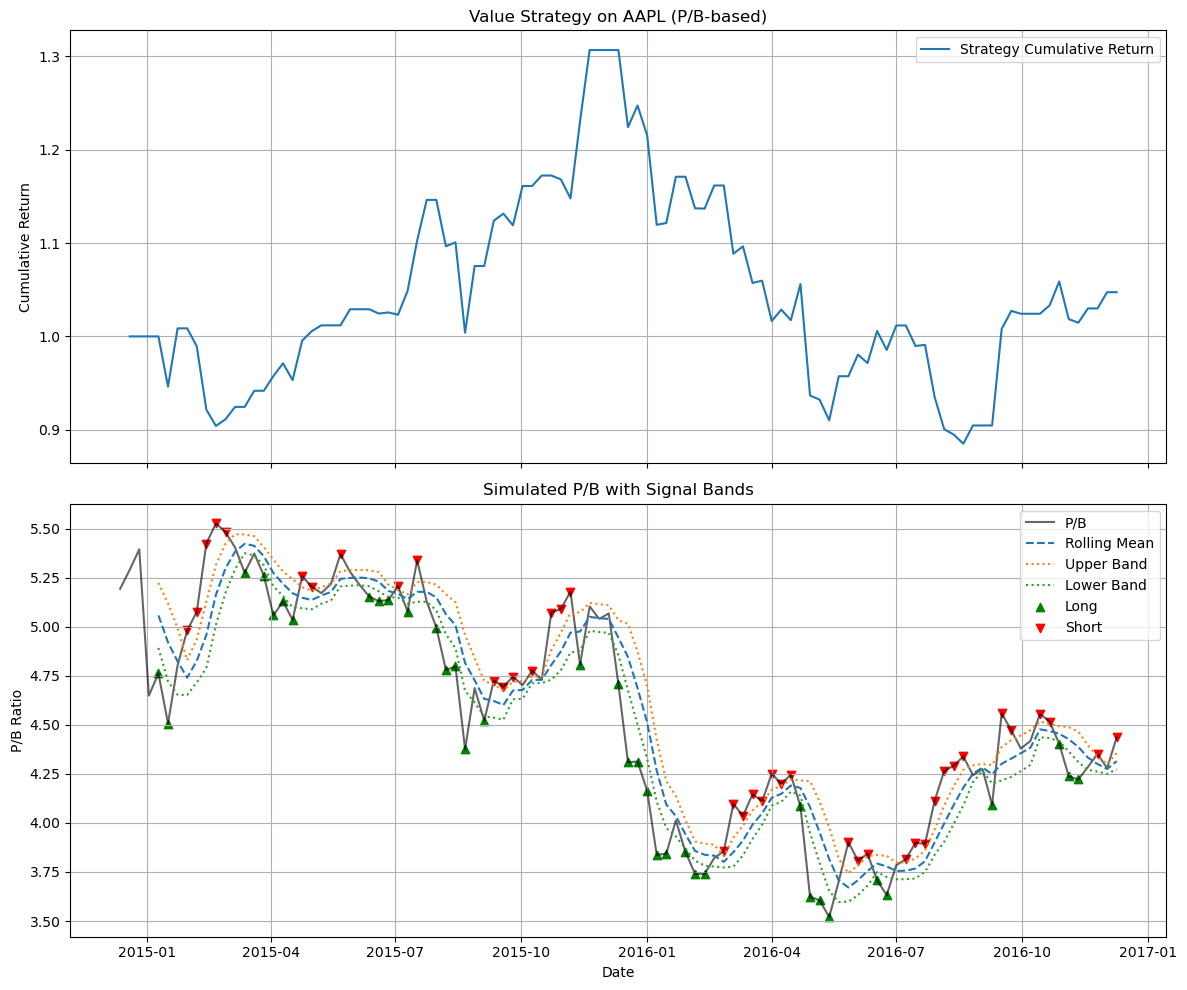

In [68]:
plot_results(cumulative_returns, pb_aapl_weekly, rolling_mean, upper_band, lower_band, signals)

In [69]:
# Define base transaction cost
base_cost = 0.001  # 0.1% per trade

# Compute rolling volatility need to choose the time frame
rolling_vol = returns.rolling(window=4).std()

# Normalize volatility relative to mean so to avoid extreme values 
scaled_vol = rolling_vol / rolling_vol.mean()

# Compute dynamic cost
dynamic_cost_per_trade = base_cost * scaled_vol

# Detect position changes (you trade only when signal changes)
position = signals.shift(1)  # Position held at each time step
position_change = position.diff().abs().fillna(0)  # 0→1 or 1→-1 etc.

# Compute transaction costs
transaction_costs = dynamic_cost_per_trade * position_change

# Apply cost to strategy returns
strategy_returns_net = strategy_returns - transaction_costs

# Recalculate cumulative returns
cumulative_returns_net = (1 + strategy_returns_net).cumprod()

# Store everything in the results DataFrame
results_df["Rolling_Vol"] = rolling_vol
results_df["Dynamic_Cost"] = transaction_costs
results_df["Strategy_Return_Net"] = strategy_returns_net
results_df["Cumulative_Return_Net"] = cumulative_returns_net

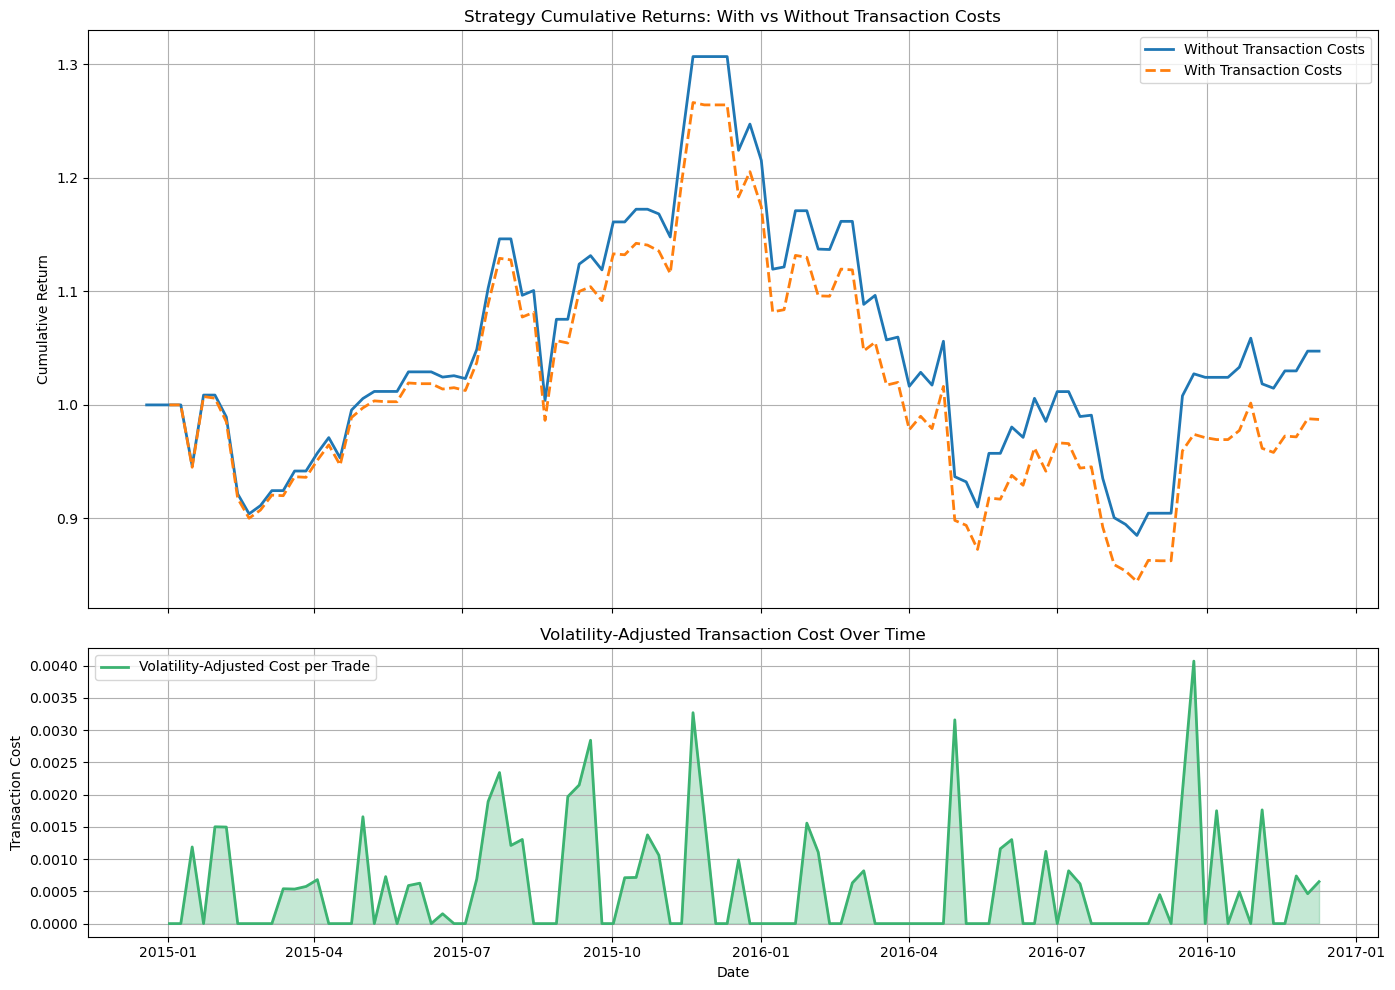

In [71]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Top plot
axs[0].plot(results_df["Cumulative_Return"], label="Without Transaction Costs", linewidth=2)
axs[0].plot(results_df["Cumulative_Return_Net"], label="With Transaction Costs", linewidth=2, linestyle='--')
axs[0].set_title("Strategy Cumulative Returns: With vs Without Transaction Costs")
axs[0].set_ylabel("Cumulative Return")
axs[0].legend()
axs[0].grid(True)

# Bottom plot
axs[1].plot(results_df["Dynamic_Cost"], label="Volatility-Adjusted Cost per Trade", color='mediumseagreen', linewidth=2)
axs[1].fill_between(results_df.index, results_df["Dynamic_Cost"], alpha=0.3, color='mediumseagreen')
axs[1].set_title("Volatility-Adjusted Transaction Cost Over Time")
axs[1].set_ylabel("Transaction Cost")
axs[1].set_xlabel("Date")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()